In [1]:
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
os.environ["MKL_THREADING_LAYER"] = "GNU"
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import random, sys, keras
import pickle

Using TensorFlow backend.


In [2]:
def network(in_shp, classes):
    from keras import backend as K
    K.set_image_dim_ordering('th')
    dr = 0.5 # dropout rate (%)
    model = models.Sequential()
    model.add(Reshape([1]+in_shp, input_shape=in_shp))
    model.add(ZeroPadding2D((0, 2)))
    model.add(Convolution2D(256, 1, 3, border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
    model.add(Dropout(dr))
    model.add(ZeroPadding2D((0, 2)))
    model.add(Convolution2D(80, 2, 3, border_mode="valid", activation="relu", name="conv2", init='glorot_uniform'))
    model.add(Dropout(dr))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
    model.add(Dropout(dr))
    model.add(Dense( len(classes), init='he_normal', name="dense2" ))
    model.add(Activation('softmax'))
    model.add(Reshape([len(classes)]))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

In [ ]:
from util import dataset_load

[X_train, Y_train, X_test, Y_test] = dataset_load('radio_data.data')


in_shp = [2,128]
classes = ['busy', 'idle']

nb_epoch = 100     # number of epochs to train on
batch_size = 1000  # training batch size

model = network(in_shp, classes)

filepath = 'QPSK.wts_new.h5'

history = model.fit(X_train,
        Y_train,
        batch_size=batch_size,
        nb_epoch=nb_epoch,
        verbose=2,
        validation_data=(X_test, Y_test),
        callbacks = [
            keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
        ])

model.load_weights(filepath)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 3), name="conv1", padding="valid", kernel_initializer="glorot_uniform", activation="relu")`
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, (2, 3), name="conv2", padding="valid", kernel_initializer="glorot_uniform", activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, name="dense1", kernel_initializer="he_normal", activation="relu")`
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, name="dense2", kernel_initializer="he_normal")`
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:

Train on 45000 samples, validate on 45000 samples
Epoch 1/100
 - 4s - loss: 0.3457 - val_loss: 0.0732
Epoch 2/100
 - 3s - loss: 0.0896 - val_loss: 0.0696
Epoch 3/100
 - 3s - loss: 0.0835 - val_loss: 0.0671
Epoch 4/100
 - 3s - loss: 0.0755 - val_loss: 0.0683
Epoch 5/100


In [27]:
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(score)

0.238374222968


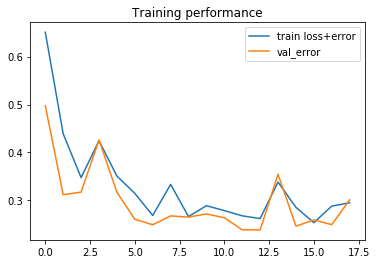

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [32]:
test_Y_hat = model.predict(X_test, batch_size=batch_size)
Y_predict = np.zeros([len(Y_test),2])
for i in range(0,X_test.shape[0]):
    k = int(np.argmax(test_Y_hat[i,:]))
    Y_predict[i, k] = 1
pd = 0
pd_count = 0
pf = 0
px = 0
for i in range(0, X_test.shape[0]):
    if Y_test[i,0] == 1:
        pd_count += 1
              
    if Y_test[i,0] == 1 and Y_predict[i,0] == 1:
        pd += 1
    if Y_test[i,0] == 0 and Y_predict[i,0] == 1:
        pf += 1
    if Y_test[i,0] == 0 and Y_predict[i,0] == 0:
        px += 1
print("pd ", pd/(pd_count + 0.0))
print("pf ", pf/(Y_test.shape[0]-pd_count + 0.0))    

pd  0.8450572459571435
pf  0.034718219305635616
